# Python Learn By Doing - Computing Plant Volume

**Author:** Lee Hathcock

## Why We Might Want to Compute Plant Volume

Late in the growing season, when canopies of various crops close together, getting plant
stand counts won't work via image recognition, and perhaps we don't want to send someone out
into the field to count the crops manually at this stage. So we turn to photogrammetry to
estimate plant volume, which can provide a stand-in for biomass measurements.

### Photogrammetry and DSMs

The way photogrammetry works is by creating a set of key points in overlapping imagery
(from a drone, for instance), and creates a point cloud out of this data. At this point, a
digital surface model (DSM) can be produced from the point cloud, and the collected imagery
can be mapped onto this DSM, creating an orthomosaic.

The point cloud produced is similar to that produced by a LIDAR payload, however the difference
is that since passive sensors (i.e. an imaging camera) are used, photogrammetry has no ability
to penetrate the canopy, so produces a DSM, which is a representation of the surface of objects
in the field of view. LIDAR, being an active sensor, has some degree of canopy penetration, and
as such can produce digital elevation models (DEMs) as well as DSMs.

We only need the surface model for this application. Photogrammetric methods can produce very
dense point clouds, so for our purposes it should perform very well.

In [1]:
# Bring in our libraries - GDAL and OSR for reading GeoTIFFs, NumPy for array
# manipulation, matplotlib for displaying imagery

import os, sys

from osgeo import gdal
from osgeo import osr
from osgeo import ogr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Working With GDAL's Warp Again and Shapefiles

As it stands, we may not want to look at the entire field, but instead clip it to get rid of
some areas we don't want affecting our count, like the trees that lie outside of the fields.

### Opening a shapefile using ogr

Hint: The syntax we're using to open our shapefile is the same as gdal, just using ogr instead.

### Getting the layer and extent

Try retrieving the extent of the shapefile using the GetLayer and GetExtent functions.

### Clipping and resampling the DSMs and orthomosaics

Try to use the GDAL Warp function as before, but add the parameters outputBounds,
xRes, yRes, and resampleAlg to clip and resize the DSM and orthomosaics to all
match each other.

Hint: Copy the Warp command from before and refer to this documentation: https://gdal.org/api/python/utilities.html#osgeo.gdal.Warp

Pay attention to the order the extent comes back in - it may not match what is needed for the Warp function.

Options for resampleAlg are here: https://gdal.org/api/gdalwarp_cpp.html#_CPPv415GDALResampleAlg

You'll probably want to keep the summertime DSM cellsize as is and use nearest neighbor for the resampleAlg,
and resample the other two using xRes and yRes, using the bilinear option for resampleAlg. Remember that you
can retrieve cellsize from the geotransform as in the other workbooks.

Note: While not an issue in this example, as all datasets are in the same projection, you may have to
change projections to match in datasets as well.

In [2]:
# We're going to clip our image files in this case using a shapefile.
filepath = './data/lah1/'

shp = ogr.Open(filepath + 'dsm_clip.shp')

# Get the extent, and then rearrange because Warp takes them in a different order
# than what is returned by GetExtent(). Specifically, it's xMin, yMin, xMax, yMax.
# GetExtent() returns xMin, xMax, yMin, yMax.

extent = shp.GetLayer().GetExtent()
extent_mod = [extent[0], extent[2], extent[1], extent[3]]

# Don't need to change the resolution of our summer DSM, but we are going to clip it
# using the shapefile - or more specifically the extent of the shapefile for simplicity.

try:
    outimg = gdal.Warp(filepath + "summer_dsm_clip.tif", filepath + "2023-07-07_USDA_NACA_400ft_dsm.tif", outputBounds = extent_mod,
                    resampleAlg="nearestneighbor", options=['COMPRESS=DEFLATE'])
except:
    outimg = gdal.Warp(filepath + "summer_dsm_clip.tif", filepath + "2023-07-07_USDA_NACA_400ft_dsm.tif", outputBounds = extent_mod,
                    resampleAlg=gdal.GRA_NearestNeighbour, options=['COMPRESS=DEFLATE'])
print (outimg)
outimg = None

# Let's open the generated GeoTIFF. Could have put this straight to memory instead.
img = gdal.Open(filepath + "summer_dsm_clip.tif")

# Get our image's geographic information
geotransform = img.GetGeoTransform()
wkt = img.GetProjection()
proj = osr.SpatialReference(wkt)

# Definitely need our x/y cell sizes for later.
xcellsize = geotransform[1]
ycellsize = geotransform[5]

# Clip our other rasters and resample to match summer DSM.
outimg = gdal.Warp(filepath + "winter_dsm_clip.tif", filepath + "2023-01-27_USDA_NACA_400ft_dsm.tif", outputBounds=extent_mod, 
                    xRes=xcellsize, yRes=ycellsize, resampleAlg=gdal.GRA_Bilinear, options=['COMPRESS=DEFLATE'])
print (outimg)
outimg = None

outimg = gdal.Warp(filepath + "summer_bgren_clip.tif", filepath + "2023-07-07_USDA_NACA_400ft_BGREN_DLS_11pTarp.tif", outputBounds=extent_mod, 
                    xRes=xcellsize, yRes=ycellsize, resampleAlg=gdal.GRA_Bilinear, options=['COMPRESS=DEFLATE'])
print (outimg)
outimg = None

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001E344ED08D0> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001E344ED09C0> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001E344ED0870> >


In [3]:
# The easiest way to change the display scale for imagery is to change the DPI.
# The larger the number, the more it will slow things down.
plt.rcParams['figure.dpi'] = 300

## Compute NDVI

Open your new resampled files and compute NDVI from it as we did in the other notebook.

In [4]:
# Let's do some band math now!

# Compute NDVI from resampled BGREN mosaic.

img = gdal.Open(filepath + "summer_bgren_clip.tif")
red = img.GetRasterBand(3).ReadAsArray()
nir = img.GetRasterBand(5).ReadAsArray()

ndvi = (nir - red)/(nir + red)

## Open DSMs and Get Difference

Open the two DSMs and subtract the winter DSM from the summer DSM to get the difference between the two.

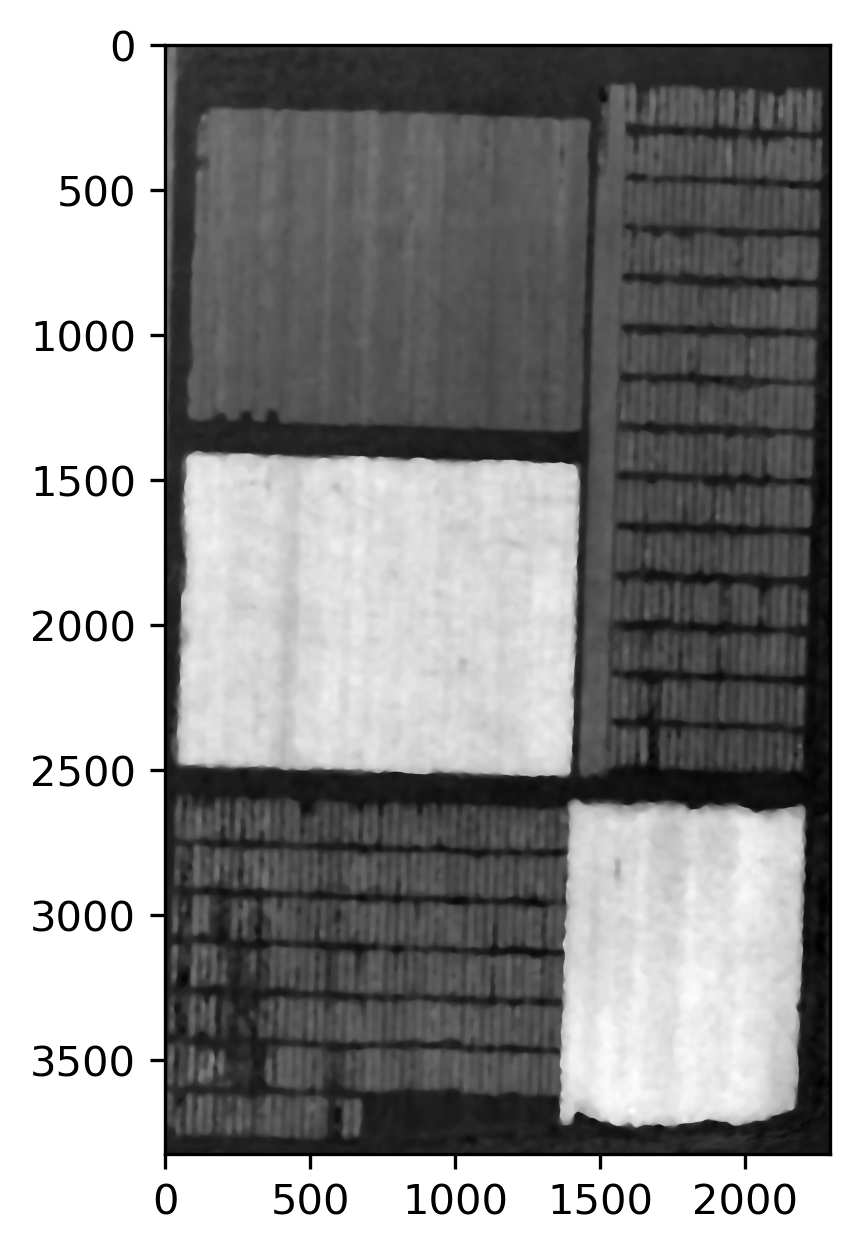

In [5]:
# Let's subtract our basemap from the summer DSM.

img = gdal.Open(filepath + "summer_dsm_clip.tif")
summer_dsm = img.GetRasterBand(1).ReadAsArray()

img = gdal.Open(filepath + "winter_dsm_clip.tif")
winter_dsm = img.GetRasterBand(1).ReadAsArray()

diff = summer_dsm - winter_dsm
imdiff = plt.imshow(diff, cmap='gray')


## Filtering Based On Plant Material

Use NumPy's where function to set our difference array to zero wherever NDVI is less than zero. Also
consider setting any negative values to zero at the same time.

0.0
2.2414246


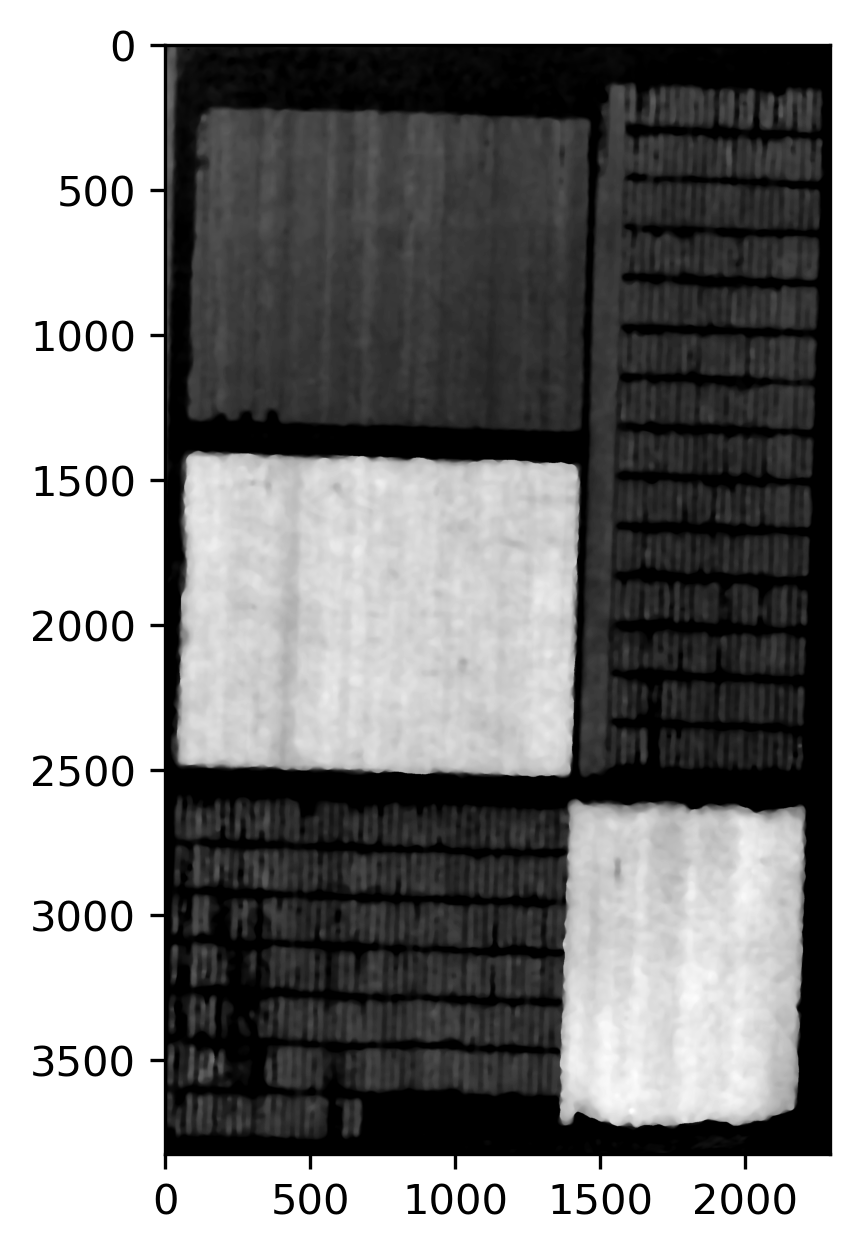

In [6]:
# Now we want to filter this for only plant material. So let's do a conditional.

# Let's also make sure we don't have negative values from vegetation that may have been present
# in winter but isn't now.

diff_filtered = np.where((ndvi < 0) | (diff < 0), 0, diff)

imdifffilt = plt.imshow(diff_filtered, cmap='gray')

print (diff_filtered.min())
print (diff_filtered.max())

## Computing Volume From Difference Array

Use the cellsize for x and y multiplied by the DSM differential array to get the volume for each pixel.

Note that cellsize might be negative, so use abs(cellsize) on them.

0.08561325258368961 -0.08559604449937738
0.003782102614646303
0.0037821026


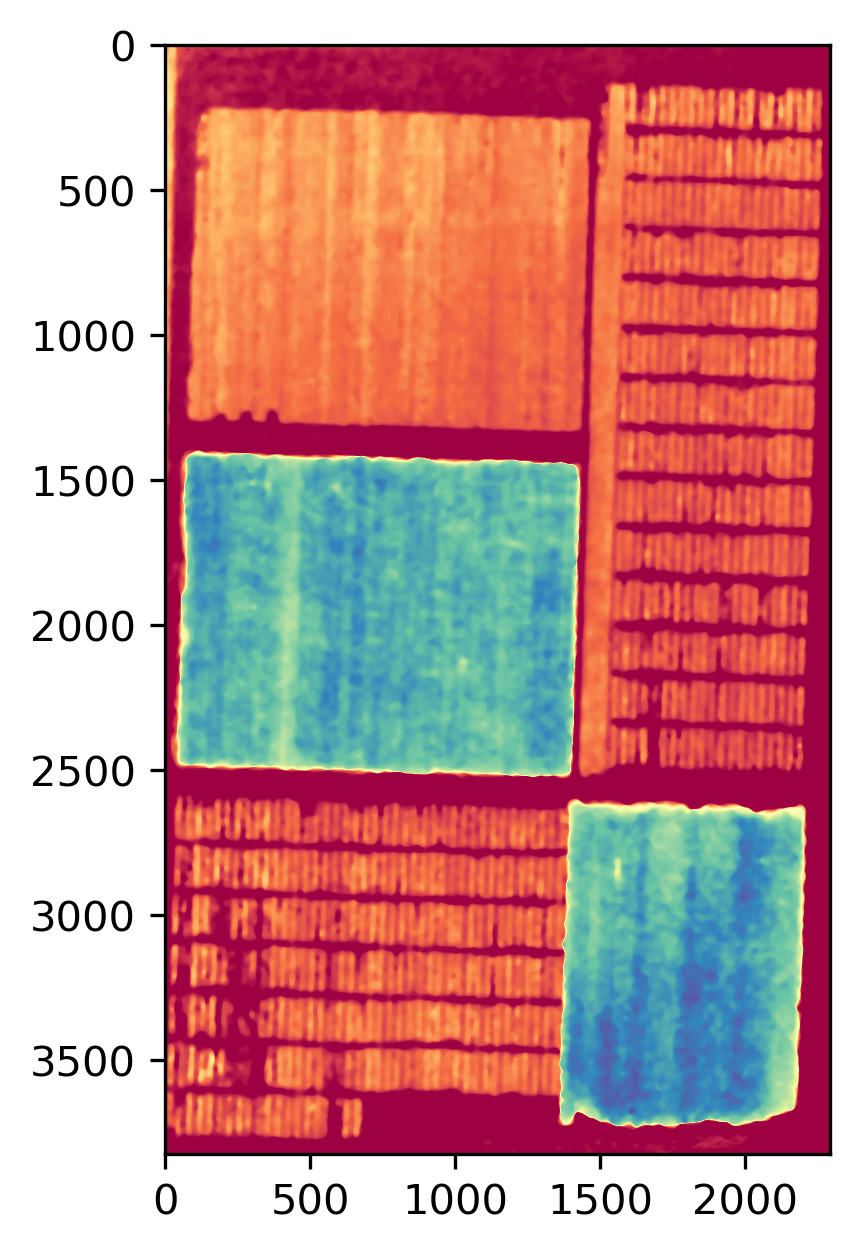

In [7]:
# Get total plant volume from DSM.

# Use X and Y resolution and height to compute volume.

print(xcellsize, ycellsize)

volume_array = diff_filtered * abs(xcellsize) * abs(ycellsize)
imvolume = plt.imshow(volume_array, cmap='Spectral')

print (diff_filtered[0][0] * abs(xcellsize) * abs(ycellsize))
print (volume_array[0][0])

## Sum Up All Values in Array

Use NumPy's sum function on the volume array we just produced to get total biomass. Assuming, of course, the underlying
field hasn't changed significantly during the elapsed time period.

In [9]:
# Now sum up all our individual volumes (per-pixel) to get total biomass.

total = np.sum(volume_array)
print ("Total volume (m^3):", total)

Total volume (m^3): 45031.887
